# Analysis - Follower/Following count

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps
import pandas as pd
import pickle
from collections import defaultdict
from sortedcontainers import SortedDict
from utils.gpu.cuda_cluster import *
from utils.gpu.preprocessing import read_data, factorize_small_cardinality

import core.config as conf


In [2]:
client

<Client: 'tcp://127.0.0.1:35135' processes=1 threads=1, memory=33.47 GB>

## 1. Load data

In [4]:
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00175'
ori_df = read_data(data_path)

In [5]:
ori_df.columns

Index(['text_ tokens', 'hashtags', 'tweet_id', 'present_media',
       'present_links', 'present_domains', 'tweet_type', 'language',
       'tweet_timestamp', 'engaged_with_user_id',
       'engaged_with_user_follower_count', 'engaged_with_user_following_count',
       'engaged_with_user_is_verified', 'engaged_with_user_account_creation',
       'enaging_user_id', 'enaging_user_follower_count',
       'enaging_user_following_count', 'enaging_user_is_verified',
       'enaging_user_account_creation', 'engagee_follows_engager',
       'reply_timestamp', 'retweet_timestamp',
       'retweet_with_comment_timestamp', 'like_timestamp'],
      dtype='object')

In [5]:
df = ori_df[['tweet_id', 'engaged_with_user_id', 'engaged_with_user_follower_count', 'engaged_with_user_following_count', 'enaging_user_id', 'enaging_user_follower_count', 'enaging_user_following_count', 'reply_timestamp', 'retweet_timestamp','retweet_with_comment_timestamp', 'like_timestamp']]

In [6]:
df['is_reply'] = df['reply_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_retweet'] = df['retweet_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_comment'] = df['retweet_with_comment_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_like'] = df['like_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)

df['is_positive'] = df[['is_like', 'is_retweet', 'is_reply', 'is_comment']].sum(axis=1).astype(np.uint8)
df['is_negative'] =  df['is_positive'].compute().applymap(lambda x: 1 if x == 0 else 0).astype(np.int32)

df = df.drop('reply_timestamp', axis=1)
df = df.drop('retweet_timestamp', axis=1)
df = df.drop('retweet_with_comment_timestamp', axis=1)
df = df.drop('like_timestamp', axis=1)

In [7]:
total_users = dask_cudf.concat([ori_df["engaged_with_user_id"], ori_df["enaging_user_id"]]).unique().compute()
df, _ = factorize_small_cardinality(df, 'engaged_with_user_id', total_users, True)
df, _ = factorize_small_cardinality(df, 'enaging_user_id', total_users, True)

total_users

0          000000B946F21610D8169031348D6748
1          0000030E0DCCFDF9DBF2DDC031E6DA58
2          0000059852AB4CDFB4C417C550780C7D
3          000005BCF00DCCEABCF7F82BDCFB3543
4          0000079F3828E08D0A604E3E0D78C91F
                         ...               
3511085    FFFFF3D18C31109B40C431CE050BEE2E
3511086    FFFFF50BA9D4FF3225576C8996BE8BAC
3511087    FFFFF7DE6B3CB775180049CB3CD337BA
3511088    FFFFF8D0A1E9C84BD356965A0C74ADB8
3511089    FFFFFA8F28C6657BA57B88D608FA2298
Length: 3511090, dtype: object

In [8]:
df = df.rename(columns={'engaged_with_user_id_encode': 'creator_id'})
df = df.rename(columns={'enaging_user_id_encode': 'engager_id'})
df = df.drop('engaged_with_user_id', axis=1)
df = df.drop('enaging_user_id', axis=1)

df = df.rename(columns={'engaged_with_user_follower_count': 'creator_follower_count'})
df = df.rename(columns={'engaged_with_user_following_count': 'creator_following_count'})
df = df.rename(columns={'enaging_user_follower_count': 'engager_follower_count'})
df = df.rename(columns={'enaging_user_following_count': 'engager_following_count'})

In [9]:
df.head()

tweet_id  creator_follower_count  \
id                                                             
1   C8F345CF8BC7A86E34572072ECFBBEC4                    4753   
2   C1E31636C343B780BA776E4B73147028                  110643   
3   B436C84E80C2430BA9DE41FDF04C73BF                    4480   
4   033FFA42C8AD502057AE96C8B4B812BE                     461   
5   84F2E902BA3CF3B34B8D056F6F78D488                    1308   

    creator_following_count  engager_follower_count  engager_following_count  \
id                                                                             
1                      1060                      76                      189   
2                       180                     260                      379   
3                      2953                    1259                      868   
4                       157                     437                      597   
5                      1478                     247                      404   

    is_reply  is_retweet  is_comment  is_like  is_positive  is_negative  \
id                                                                        
1          0           0           0        1            1            0   
2          0           0           0        0            0            1   
3          1           0           0        0            1            0   
4          0           0           0        1            1            0   
5          0           0           0        0            0            1   

    creator_id  engager_id  
id                          
1      2586120      893844  
2      3355961     3173376  
3      1233947      951213  
4      3063535     2013995  
5      2280964     3018294

In [10]:
df.compute().describe().astype(np.int64)

creator_follower_count  creator_following_count  \
count                 3033347                  3033347   
mean                   751526                     3613   
std                   4436788                    33051   
min                         1                        0   
25%                       817                      203   
50%                      5592                      565   
75%                     88088                     1471   
max                 129240509                  4256371   

       engager_follower_count  engager_following_count  is_reply  is_retweet  \
count                 3033347                  3033347   3033347     3033347   
mean                      827                      706         0           0   
std                     31759                     1586         0           0   
min                         0                        1         0           0   
25%                        70                      153         0           0   
50%                       210                      334         0           0   
75%                       577                      735         0           0   
max                  51817106                   402187         1           1   

       is_comment  is_like  is_positive  is_negative  creator_id  engager_id  
count     3033347  3033347      3033347      3033347     3033347     3033347  
mean            0        0            0            0     1760479     1755944  
std             0        0            0            0     1012183     1013640  
min             0        0            0            0           4           0  
25%             0        0            0            0      890127      878121  
50%             0        0            0            1     1761731     1756012  
75%             0        1            1            1     2637234     2634005  
max             1        1            4            1     3511089     3511088

In [11]:
creator_engagements = df.groupby('creator_id')[['is_reply',	'is_retweet',	'is_comment',	'is_like',	'is_positive',	'is_negative']].sum().compute()
creator_engagements = creator_engagements.reset_index()
creator_engagements.head()

creator_follower_count = df.compute().groupby('creator_id')[['creator_follower_count']].nth(-1)
creator_follower_count = creator_follower_count.reset_index()

creator_following_count = df.compute().groupby('creator_id')[['creator_following_count']].nth(-1)
creator_following_count = creator_following_count.reset_index()

engager_follower_count = df.compute().groupby('creator_id')[['engager_follower_count']].nth(-1)
engager_follower_count = engager_follower_count.reset_index()

engager_following_count = df.compute().groupby('creator_id')[['engager_following_count']].nth(-1)
engager_following_count = engager_following_count.reset_index()


follow_count_df = creator_engagements.merge(creator_follower_count, on=['creator_id'], how='left')
follow_count_df = follow_count_df.merge(creator_following_count, on=['creator_id'], how='left')
follow_count_df = follow_count_df.merge(engager_follower_count, on=['creator_id'], how='left')
follow_count_df = follow_count_df.merge(engager_following_count, on=['creator_id'], how='left')



In [12]:
len(follow_count_df)

1558866

In [13]:
follow_count_df.head()

creator_id  is_reply  is_retweet  is_comment  is_like  is_positive  \
0      130754         0           1           0        0            1   
1     2962551         0           0           0        0            0   
2     2943226         0           0           0        0            0   
3     1379162         0           1           0        1            2   
4      102981         0           0           0        1            1   

   is_negative  creator_follower_count  creator_following_count  \
0            0                    2276                      522   
1            1                     123                      326   
2            1                      18                       98   
3            0                    4142                      753   
4            2                    2051                      108   

   engager_follower_count  engager_following_count  
0                     757                     2242  
1                     522                      651  
2                      93                      209  
3                     287                      714  
4                     147                      916

In [14]:
follow_count_df.describe().astype(np.int64)

creator_id  is_reply  is_retweet  is_comment  is_like  is_positive  \
count     1558866   1558866     1558866     1558866  1558866      1558866   
mean      1755430         0           0           0        0            1   
std       1013549         0           1           0        4            5   
min             4         0           0           0        0            0   
25%        877468         0           0           0        0            0   
50%       1755200         0           0           0        0            1   
75%       2633364         0           0           0        1            1   
max       3511089       126         474          36     1324         1562   

       is_negative  creator_follower_count  creator_following_count  \
count      1558866                 1558866                  1558866   
mean             0                   28492                     1820   
std              4                  460536                    12494   
min              0                       1                        0   
25%              0                     359                      221   
50%              1                    1139                      532   
75%              1                    4624                     1288   
max           1080               129240509                  4256371   

       engager_follower_count  engager_following_count  
count                 1558866                  1558866  
mean                      942                      765  
std                     11151                     1758  
min                         0                        1  
25%                        99                      166  
50%                       271                      359  
75%                       711                      791  
max                   5211678                   402187

## 2. creator - follower count

In [45]:
sorted_creator_follower = follow_count_df.sort_values('creator_follower_count', ascending=False)

top_n = 1000000
top_n_creator = sorted_creator_follower[:top_n]
top_n_creator.describe().astype(np.int64)

creator_id  is_reply  is_retweet  is_comment  is_like  is_positive  \
count     1000000   1000000     1000000     1000000  1000000      1000000   
mean      1754651         0           0           0        0            1   
std       1013751         0           1           0        5            7   
min             4         0           0           0        0            0   
25%        875947         0           0           0        0            0   
50%       1753745         0           0           0        0            1   
75%       2632910         0           0           0        1            1   
max       3511084       126         474          36     1324         1562   

       is_negative  creator_follower_count  creator_following_count  \
count      1000000                 1000000                  1000000   
mean             1                   44268                     2638   
std              5                  574397                    15537   
min              0                     600                        0   
25%              0                    1238                      400   
50%              1                    2875                      902   
75%              1                   10449                     2084   
max           1080               129240509                  4256371   

       engager_follower_count  engager_following_count  
count                 1000000                  1000000  
mean                     1155                      918  
std                     12632                     2037  
min                         0                        1  
25%                       110                      204  
50%                       323                      442  
75%                       881                      966  
max                   5211678                   402187

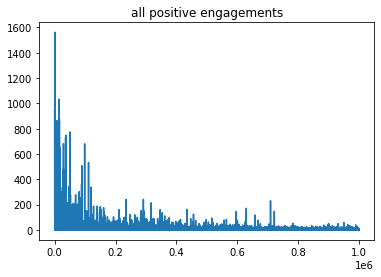

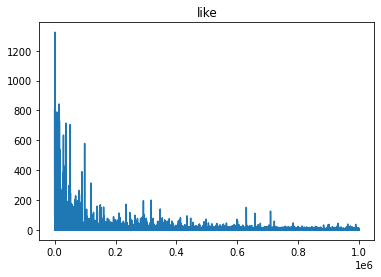

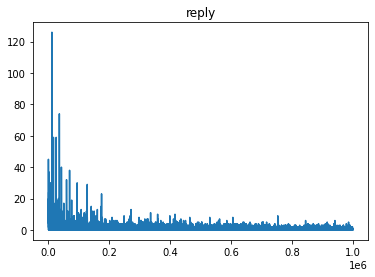

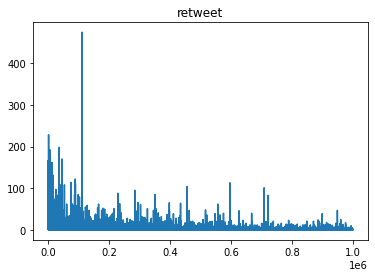

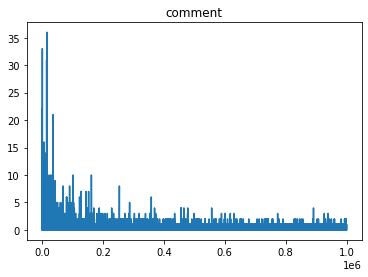

In [46]:
plt.title('all positive engagements')
plt.plot(range(top_n), top_n_creator['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(range(top_n), top_n_creator['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(range(top_n), top_n_creator['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(range(top_n), top_n_creator['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(range(top_n), top_n_creator['is_comment'].to_array())
plt.show()

## 3. creator - following count

In [47]:
sorted_creator_following = follow_count_df.sort_values('creator_following_count', ascending=False)

top_n_creator = sorted_creator_following[:top_n]
top_n_creator.describe().astype(np.int64)

creator_id  is_reply  is_retweet  is_comment  is_like  is_positive  \
count     1000000   1000000     1000000     1000000  1000000      1000000   
mean      1755517         0           0           0        0            0   
std       1013762         0           1           0        4            5   
min            10         0           0           0        0            0   
25%        877047         0           0           0        0            0   
50%       1754808         0           0           0        0            0   
75%       2633845         0           0           0        1            1   
max       3511089       126         474          36      843         1033   

       is_negative  creator_follower_count  creator_following_count  \
count      1000000                 1000000                  1000000   
mean             0                   26227                     2747   
std              3                  425810                    15522   
min              0                       3                      335   
25%              0                     683                      566   
50%              1                    1651                      965   
75%              1                    5608                     2122   
max           1080               129240509                  4256371   

       engager_follower_count  engager_following_count  
count                 1000000                  1000000  
mean                     1148                      929  
std                     10089                     2064  
min                         0                        1  
25%                       136                      214  
50%                       359                      450  
75%                       921                      970  
max                   3604236                   402187

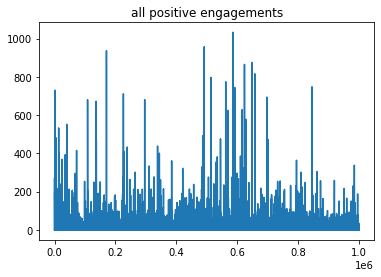

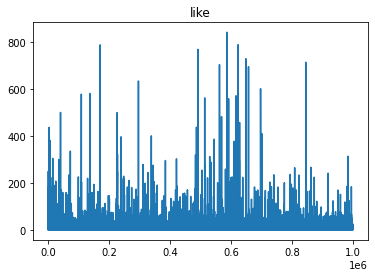

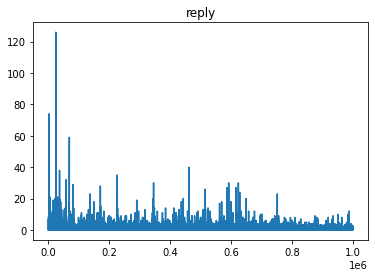

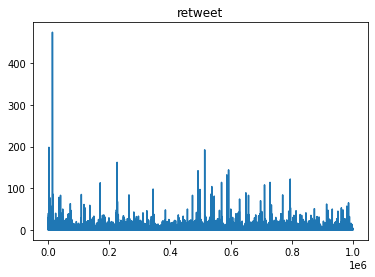

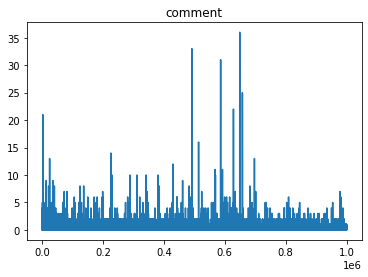

In [48]:
plt.title('all positive engagements')
plt.plot(range(top_n), top_n_creator['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(range(top_n), top_n_creator['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(range(top_n), top_n_creator['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(range(top_n), top_n_creator['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(range(top_n), top_n_creator['is_comment'].to_array())
plt.show()

## 4. engager - follower count

In [49]:
sorted_engager_follower = follow_count_df.sort_values('engager_follower_count', ascending=False)

top_n_engager = sorted_engager_follower[:top_n]
top_n_engager.describe().astype(np.int64)

creator_id  is_reply  is_retweet  is_comment  is_like  is_positive  \
count     1000000   1000000     1000000     1000000  1000000      1000000   
mean      1755546         0           0           0        0            0   
std       1013354         0           1           0        3            4   
min            10         0           0           0        0            0   
25%        878456         0           0           0        0            0   
50%       1754510         0           0           0        0            0   
75%       2633386         0           0           0        1            1   
max       3511089       126         474          31      843         1033   

       is_negative  creator_follower_count  creator_following_count  \
count      1000000                 1000000                  1000000   
mean             0                   22452                     2207   
std              3                  431484                    13527   
min              0                       1                        0   
25%              0                     432                      294   
50%              1                    1211                      666   
75%              1                    4217                     1629   
max           1080               129240509                  2241773   

       engager_follower_count  engager_following_count  
count                 1000000                  1000000  
mean                     1429                     1063  
std                     13899                     2125  
min                       159                        1  
25%                       290                      307  
50%                       527                      563  
75%                      1133                     1115  
max                   5211678                   402187

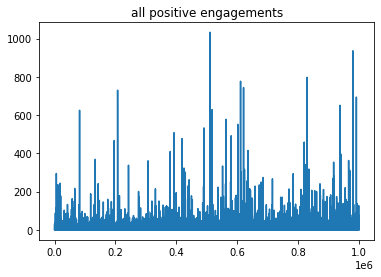

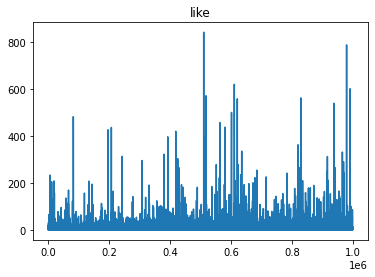

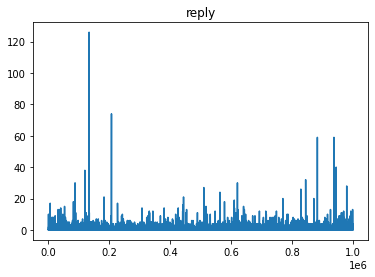

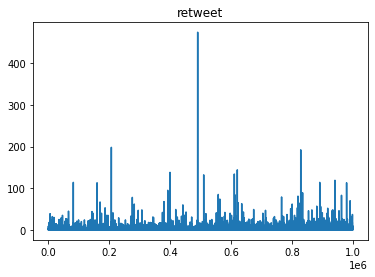

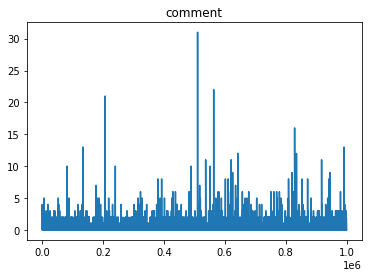

In [50]:
plt.title('all positive engagements')
plt.plot(range(top_n), top_n_engager['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(range(top_n), top_n_engager['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(range(top_n), top_n_engager['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(range(top_n), top_n_engager['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(range(top_n), top_n_engager['is_comment'].to_array())
plt.show()

## 5. engager - following count

In [51]:
sorted_engager_following = follow_count_df.sort_values('engager_following_count', ascending=False)

top_n_engager = sorted_engager_following[:top_n]
top_n_engager.describe().astype(np.int64)

creator_id  is_reply  is_retweet  is_comment  is_like  is_positive  \
count     1000000   1000000     1000000     1000000  1000000      1000000   
mean      1754784         0           0           0        0            0   
std       1013690         0           1           0        4            4   
min            10         0           0           0        0            0   
25%        876467         0           0           0        0            0   
50%       1753913         0           0           0        0            0   
75%       2632900         0           0           0        1            1   
max       3511084       126         474          31      843         1033   

       is_negative  creator_follower_count  creator_following_count  \
count      1000000                 1000000                  1000000   
mean             0                   27852                     2235   
std              3                  445940                    13503   
min              0                       1                        0   
25%              0                     493                      297   
50%              1                    1451                      684   
75%              1                    5518                     1666   
max           1080               129240509                  2241773   

       engager_follower_count  engager_following_count  
count                 1000000                  1000000  
mean                     1339                     1123  
std                     13625                     2112  
min                         0                      237  
25%                       237                      379  
50%                       488                      616  
75%                      1087                     1157  
max                   5211678                   402187

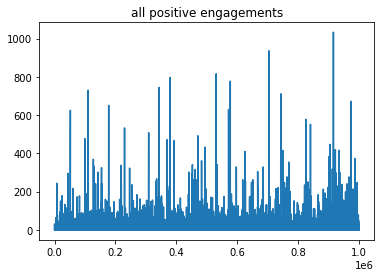

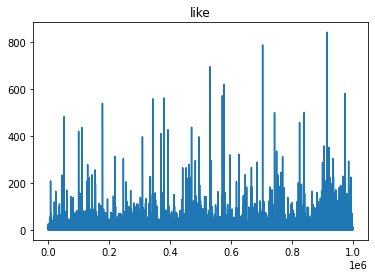

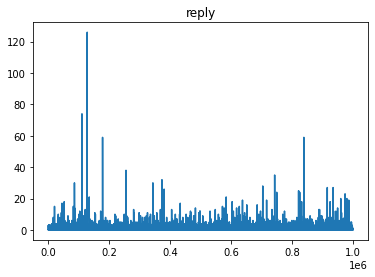

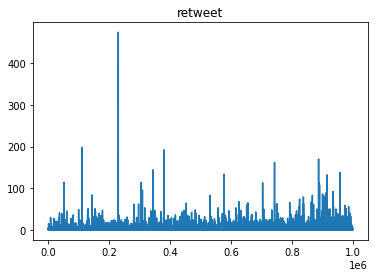

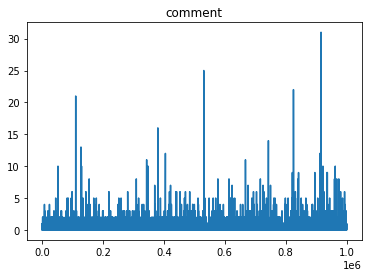

In [52]:
plt.title('all positive engagements')
plt.plot(range(top_n), top_n_engager['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(range(top_n), top_n_engager['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(range(top_n), top_n_engager['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(range(top_n), top_n_engager['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(range(top_n), top_n_engager['is_comment'].to_array())
plt.show()

## 6. The creator's (follower/following) count of popular tweets

In [23]:
df

<dask_cudf.DataFrame | 144 tasks | 16 npartitions>

In [24]:
popular_tweet = df.groupby('tweet_id')[['is_reply',	'is_retweet',	'is_comment',	'is_like',	'is_positive',	'is_negative']].sum().compute()
popular_tweet = popular_tweet.reset_index()

tweet_creator_id = df.compute().groupby('tweet_id')[['creator_id', 'creator_follower_count', 'creator_following_count']].nth(-1)
tweet_creator_id = tweet_creator_id.reset_index()

tweet_df = popular_tweet.merge(tweet_creator_id, on=['tweet_id'], how='left')
tweet_df.head()

tweet_id  is_reply  is_retweet  is_comment  \
0  81446177EB536194E15306C715884E28         0           0           0   
1  A8C4718B78A571EBE174759E5ACF1149         0           0           0   
2  2450EAABCAF2FDDF0792A2CF7EA82CB7         0           0           0   
3  3A1E481848E92A49794BED8AF3F8262F         0           0           0   
4  AE021183A4B427CCBE29FDC0C3E701DB         0           0           0   

   is_like  is_positive  is_negative  creator_id  creator_follower_count  \
0        0            0            1     1859510                   26812   
1        0            0            1     2167866                   22572   
2        0            0            1      733890                      93   
3        0            0            1      916934                     764   
4        1            1            0     2831995                   22110   

   creator_following_count  
0                      731  
1                    14460  
2                       98  
3                      840  
4                      998

In [25]:
sorted_tweet_df = tweet_df.sort_values('is_positive', ascending=False)
sorted_tweet_df.head()

tweet_id  is_reply  is_retweet  is_comment  \
2293934  AE62799DC2A663D542FB92AAF531E5D1         7          24           9   
1588880  DED14B41C913E6425B28872A56E3722A         0          25           0   
816100   BD02ABF1B2BAEB8D08AAFE64999DC139         2          19           1   
351644   A65DCAF8A3ED15A96F2AFA73884C8A28         1          24           2   
914840   78ACF588A9D5FAF356BF63B3EE38F9B5         2          22           0   

         is_like  is_positive  is_negative  creator_id  \
2293934       70          110           14     1078589   
1588880       73           98            8     1078589   
816100        69           91            9     1078589   
351644        63           90            6     1078589   
914840        66           90           14     1078589   

         creator_follower_count  creator_following_count  
2293934                32807755                      141  
1588880                32807755                      141  
816100                 32807755                      141  
351644                 32807755                      141  
914840                 32807755                      141

In [52]:
top_n_popular_tweet = sorted_tweet_df[:top_n]
top_n_popular_tweet.describe().astype(np.int64)

is_reply  is_retweet  is_comment  is_like  is_positive  is_negative  \
count     10000       10000       10000    10000        10000        10000   
mean          0           0           0        4            5            1   
std           0           1           0        3            4            1   
min           0           0           0        0            3            0   
25%           0           0           0        3            4            0   
50%           0           1           0        4            5            0   
75%           0           1           0        5            6            1   
max           7          25           9       73          110           21   

       creator_id  creator_follower_count  creator_following_count  
count       10000                   10000                    10000  
mean      1817843                 5039453                     5269  
std       1019797                11518097                    36429  
min          2679                      29                        0  
25%        966112                  267094                       76  
50%       1861409                 1100449                      464  
75%       2724332                 4533625                     1082  
max       3508189               129240509                  1144037

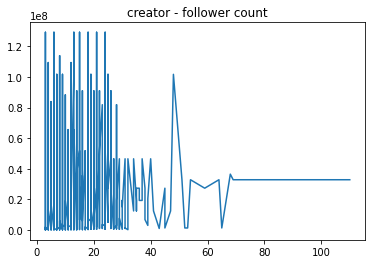

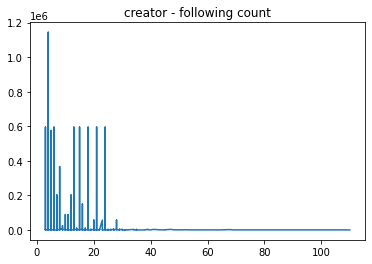

In [55]:

plt.title('creator - follower count')
plt.plot(range(top_n), top_n_popular_tweet['creator_follower_count'].to_array())
plt.show()

plt.title('creator - following count')
plt.plot(range(top_n), top_n_popular_tweet['creator_following_count'].to_array())
plt.show()


## number of follower count

In [3]:
with open('/hdd/analysis/follower_count.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
sd = SortedDict(data)

In [7]:
len(sd)

159945

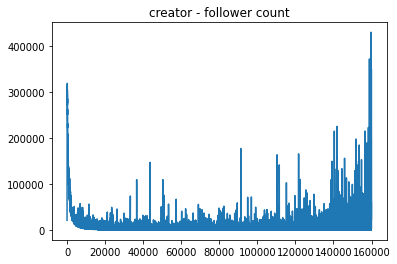

In [10]:
plt.title('creator - follower count')
plt.plot(list(sd.values()))
plt.show()